In [1]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import product

from scipy.stats import linregress

import sys
sys.path.append('../funcs')
sys.path.append('../constants')
from taus import decorrelation_temporal_model, fit_coh_decay_model
from colors import loc_colors

In [2]:
dss = {fp.stem: xr.open_dataset(fp) for fp in sorted(list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*.nc')))}

home_dir = Path('/Users/rdcrlzh1/Documents/uavsar-coherence')
fig_dir = home_dir.joinpath('figures', 'non-snow')

In [ ]:
# index=pd.MultiIndex(levels=[[], []], labels=[[], []], names=['subj_id', 'org_clip']),
                #   columns=['predicted_y', 'actual_y', 'predicted_full', 'actual_full'])

res = pd.DataFrame(index = pd.MultiIndex(levels = [[], [], []], codes = [[], [],[]], names = ['site', 'dt', 'pol']), columns = ['25', '50', '75'])

pol_cor = {pol: np.array([]) for pol in ['VV', 'HV', 'VH', 'HH']}
trees = [np.array([]), np.array([])]
vh = [np.array([]), np.array([])]
inc = [np.array([]), np.array([])]
lc_dic = {'water': [11,11], 'developed': [21,24], 'forest': [41, 43], 'shrub': [51, 52], 'herbaceous': [71, 74]}
lc = {lc_class: np.array([]) for lc_class in lc_dic.keys()}

for stem, ds_full in dss.items():
    # if stem != 'grmesa_full': continue
    print(stem)
    for t1, t2 in product(ds_full.time1, ds_full.time2):
        if (~ds_full['cor'].sel(time1 = t1, time2 = t2).isel(heading = 0, pol = 0).isnull()).sum() == 0: continue
        # ds = ds.where((ds['inc'] < np.deg2rad(50)) & (ds['inc'] < np.deg2rad(30)))
        ds = ds_full.sel(time1 = t1, time2 = t2)
        
        # polarization
        for pol in ds.pol.values:
            # if pol == 'HH': continue
            # Temporal Decorrelation
            dt = pd.Timedelta(t2.values - t1.values)
            res.loc[(stem.replace('_full',''), dt, pol), ['25', '50', '75']] = ds['cor'].sel(pol = pol).quantile([0.25, 0.5, 0.75]).values.ravel()
            res.loc[(stem.replace('_full',''), dt, pol), 'days'] = dt.days
            
            # Polarization
            cor = ds['cor'].sel(pol = pol).values.ravel()
            cor = cor[~np.isnan(cor)]
            pol_cor[pol] = np.concatenate([pol_cor[pol], cor])
            
        main_pol = 'HH'
        ds = ds.sel(pol = main_pol)
        # if dt.days > 14:
            # continue
        
        for heading in ds.heading.values:
            # tree height
            if dt.days < 10:
                tree, cor, i = ds['tree_perc'].values.ravel(), ds['cor'].sel(heading = heading).values.ravel(), ds['inc'].sel(heading = heading).values.ravel()
                tree_idx = (~np.isnan(tree)) & (~np.isnan(cor)) & (i < np.deg2rad(60))
                tree, cor = tree[tree_idx], cor[tree_idx]
                trees[0] = np.concatenate([trees[0], tree])
                trees[1] = np.concatenate([trees[1], cor])

            # land cover
            for title, [low, upper] in lc_dic.items():
                landcover, cor = ds['land_cover'].values.ravel(), ds['cor'].sel(heading = heading).where((ds['land_cover'] >= low) & (ds['land_cover'] <= upper)).values.ravel()
                landcover_idx = (~np.isnan(landcover)) & (~np.isnan(cor)) #& (tree > 1)
                landcover, cor = landcover[landcover_idx], cor[landcover_idx]
                lc[title] = np.concatenate([lc[title], cor])

            # incidence angle
            i, cor = ds['inc'].sel(heading = heading).values.ravel(), ds['cor'].sel(heading = heading).values.ravel()
            inc_idx = (~np.isnan(i)) & (~np.isnan(cor)) & (i < np.deg2rad(90))
            i, cor = i[inc_idx], cor[inc_idx]
            inc[0] = np.concatenate([inc[0], i])
            inc[1] = np.concatenate([inc[1], cor])

            # vh
            if 'vh' in ds.data_vars:
                    tree, cor = ds['vh'].values.ravel(), ds['cor'].sel(heading = heading).values.ravel()
                    tree_idx = (~np.isnan(tree)) & (~np.isnan(cor)) # & (tree > 1)
                    tree, cor = tree[tree_idx], cor[tree_idx]
                    vh[0] = np.concatenate([vh[0], tree])
                    vh[1] = np.concatenate([vh[1], cor])


In [70]:
cmap = mpl.colormaps['Greys']
fig, axes = plt.subplots(1, 2)
cors = np.array([])
cors60 = np.array([])
cors90 = np.array([])
cors300 = np.array([])
cors900 = np.array([])

for stem, ds_full in dss.items():
    # if stem == 'fraser_full': break
    ds_full = ds_full.sel(pol = 'HH')['cor']
    print(stem)
    site_color, site_name = loc_colors[stem.replace('_full', '')].values()
    sns.kdeplot(ds_full.values.ravel(), label = site_name, color = site_color,ax = axes[1]) 

    cors = np.concatenate([cors, ds_full.values.ravel()])
    cors60 = np.concatenate([cors60, ds_full.coarsen(x = 2, y = 2, boundary = 'trim').mean().values.ravel()])
    cors90 = np.concatenate([cors90, ds_full.coarsen(x = 3, y = 3, boundary = 'trim').mean().values.ravel()])
    cors300 = np.concatenate([cors300, ds_full.coarsen(x =10, y = 10, boundary = 'trim').mean().values.ravel()])
    cors900 = np.concatenate([cors900, ds_full.coarsen(x = 30, y = 30, boundary = 'trim').mean().values.ravel()])
sns.kdeplot(cors, ax = axes[0], label = '5 looks [30 m]', color = cmap(30/900))
sns.kdeplot(cors60, ax = axes[0], label = '10 looks [60 m]', color = cmap(60/900))
sns.kdeplot(cors90, ax = axes[0], label = '15 looks [90 m]', color = cmap(90/900))
sns.kdeplot(cors300, ax = axes[0], label = '50 looks [300 m]', color = cmap(300/900))
sns.kdeplot(cors900, ax = axes[0], label = '150 looks [900 m]', color = cmap(900/900))
axes[0].legend()
axes[1].legend()

alamos_full
donner_full
dorado_full
fraser_full
grmesa_full
irnton_full
lowman_full


Tau: 4.60426883226439
FCF Slope: -0.0014531556656793107. p: 0.0
VH Slope: -0.0029391049211197184. p: 1.812192177177763e-14
Slope: -0.0017963187875798872. p: 0.0
Slope: -0.008334805129925894. p: 0.0


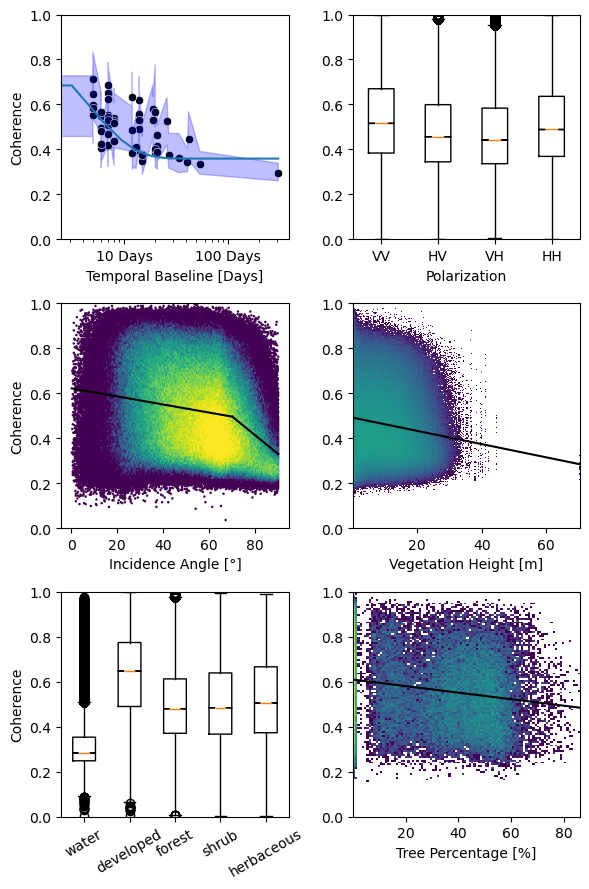

In [10]:
fig, axes = plt.subplots(3, 2, figsize = (6, 9))
pol = 'HH'

# temporal decorrelation
ax = axes.ravel()[0]
sns.scatterplot(data = res.loc[idx[:,:,pol]], x = 'days', y = '50', ax = ax, color = 'black') #, hue = 'site'
res = res.sort_values('dt')
x = res.loc[idx[:,:,pol]].days.values
y = res.loc[idx[:,:,pol]]['50'].values.astype(float)
y_bot, y_top = (res.loc[idx[:,:,pol]]['25'].values).astype(float), (res.loc[idx[:,:,pol]]['75'].values).astype(float)
ax.fill_between(x, y_bot, y_top, alpha = 0.25, color = 'blue')

# fit exponential model
x, y = x[(~np.isnan(x)) & (~np.isnan(y))], y[(~np.isnan(x)) & (~np.isnan(y))]
ginf, tau, _ = fit_coh_decay_model(y, x, 4, [[0, 1], [1, 10]], 1, 1, gamma_inf_guess=0.2)
xs = np.linspace(0, np.nanmax(x), 100)
ax.plot(xs, decorrelation_temporal_model(xs, ginf, tau))
print(f'Tau: {tau}')

ax.set_xscale('log')
ax.set_xticks([10, 100], ['10 Days', '100 Days'])
ax.set_xlabel('Temporal Baseline [Days]')

# polarization
ax = axes.ravel()[1]
ax.boxplot(pol_cor.values(), notch = True)
ax.set_xticks(np.arange(1, 5, 1), pol_cor.keys())
ax.set_xlabel('Polarization')


# tree %
ax = axes.ravel()[5]
# a little jitter to reduce lines on this plot
ax.hist2d(x = trees[0][::1000] + np.random.random(len(trees[0][::1000])), y = trees[1][::1000], bins = 100, norm = mpl.colors.LogNorm())
ax.set_xlabel('Tree Percentage [%]')
x = trees[0][::1000]
y = trees[1][::1000]
lm = linregress(x = x, y = y)
xs = np.linspace(np.min(x), np.max(x), 100)
ys = lm.slope * xs + lm.intercept
ax.plot(xs, ys, color = 'black')
print(f'FCF Slope: {lm.slope}. p: {lm.pvalue}')

# vegetation height
ax = axes.ravel()[3]
ax.hist2d(x = vh[0], y = vh[1], bins = 200, norm = mpl.colors.LogNorm())
ax.set_xlabel('Vegetation Height [m]')
x = vh[0][::1000]
y = vh[1][::1000]
lm = linregress(x = x, y = y)
xs = np.linspace(np.min(x), np.max(x), 100)
ys = lm.slope * xs + lm.intercept
ax.plot(xs, ys, color = 'black')
print(f'VH Slope: {lm.slope}. p: {lm.pvalue}')

# landcover
ax = axes.ravel()[4]
ax.boxplot(lc.values(), notch = True)
ax.set_xticks(np.arange(1, len(lc)+1, 1), lc.keys(), rotation = 30)
ax.set_xlabel('') # Land Cover

# incidence angle
ax = axes.ravel()[2]
# ax.hist2d(x = np.rad2deg(inc[0][::100]), y = inc[1][::100], bins = 100, range = [[0,90], [0, 1]], norm=mpl.colors.LogNorm())
ax.hexbin(x = np.rad2deg(inc[0][::100]), y = inc[1][::100], gridsize = 200, norm = mpl.colors.LogNorm(vmin = 10, vmax = 100))#, range = [[0,90], [0, 1]])#, norm=mpl.colors.LogNorm())
ax.set_xlabel('Incidence Angle [°]')
x = np.rad2deg(inc[0][::100])
y = inc[1][::100]
index = (x > 0) & (x < 70)
x, y = x[index], y[index]
lm = linregress(x = x, y = y)
xs = np.linspace(np.min(x), np.max(x), 100)
ys = lm.slope * xs + lm.intercept
ax.plot(xs, ys, color = 'black')
print(f'Slope: {lm.slope}. p: {lm.pvalue}')
x = np.rad2deg(inc[0][::100])
y = inc[1][::100]
index = (x > 70)
x, y = x[index], y[index]
lm = linregress(x = x, y = y)
xs = np.linspace(np.min(x), np.max(x), 100)
ys = lm.slope * xs + lm.intercept
ax.plot(xs, ys, color = 'black')
print(f'Slope: {lm.slope}. p: {lm.pvalue}')

for ax in axes[:, 0]:
    ax.set_ylabel('Coherence')

for ax in axes.ravel():
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(fig_dir.joinpath('non-snow-overall.png'))

fraser_full
Inc Slope: -0.0039037048170588156 []/°. p: 0.0. n = 884523
lowman_full
Inc Slope: -0.00284083658179222 []/°. p: 0.0. n = 2123434
rockmt_full
Inc Slope: -0.004573524310534301 []/°. p: 0.0. n = 786865
sierra_full
Inc Slope: -0.0035491480798297346 []/°. p: 0.0. n = 1233830
stlake_full
Inc Slope: -0.0028466696533065087 []/°. p: 0.0. n = 600054


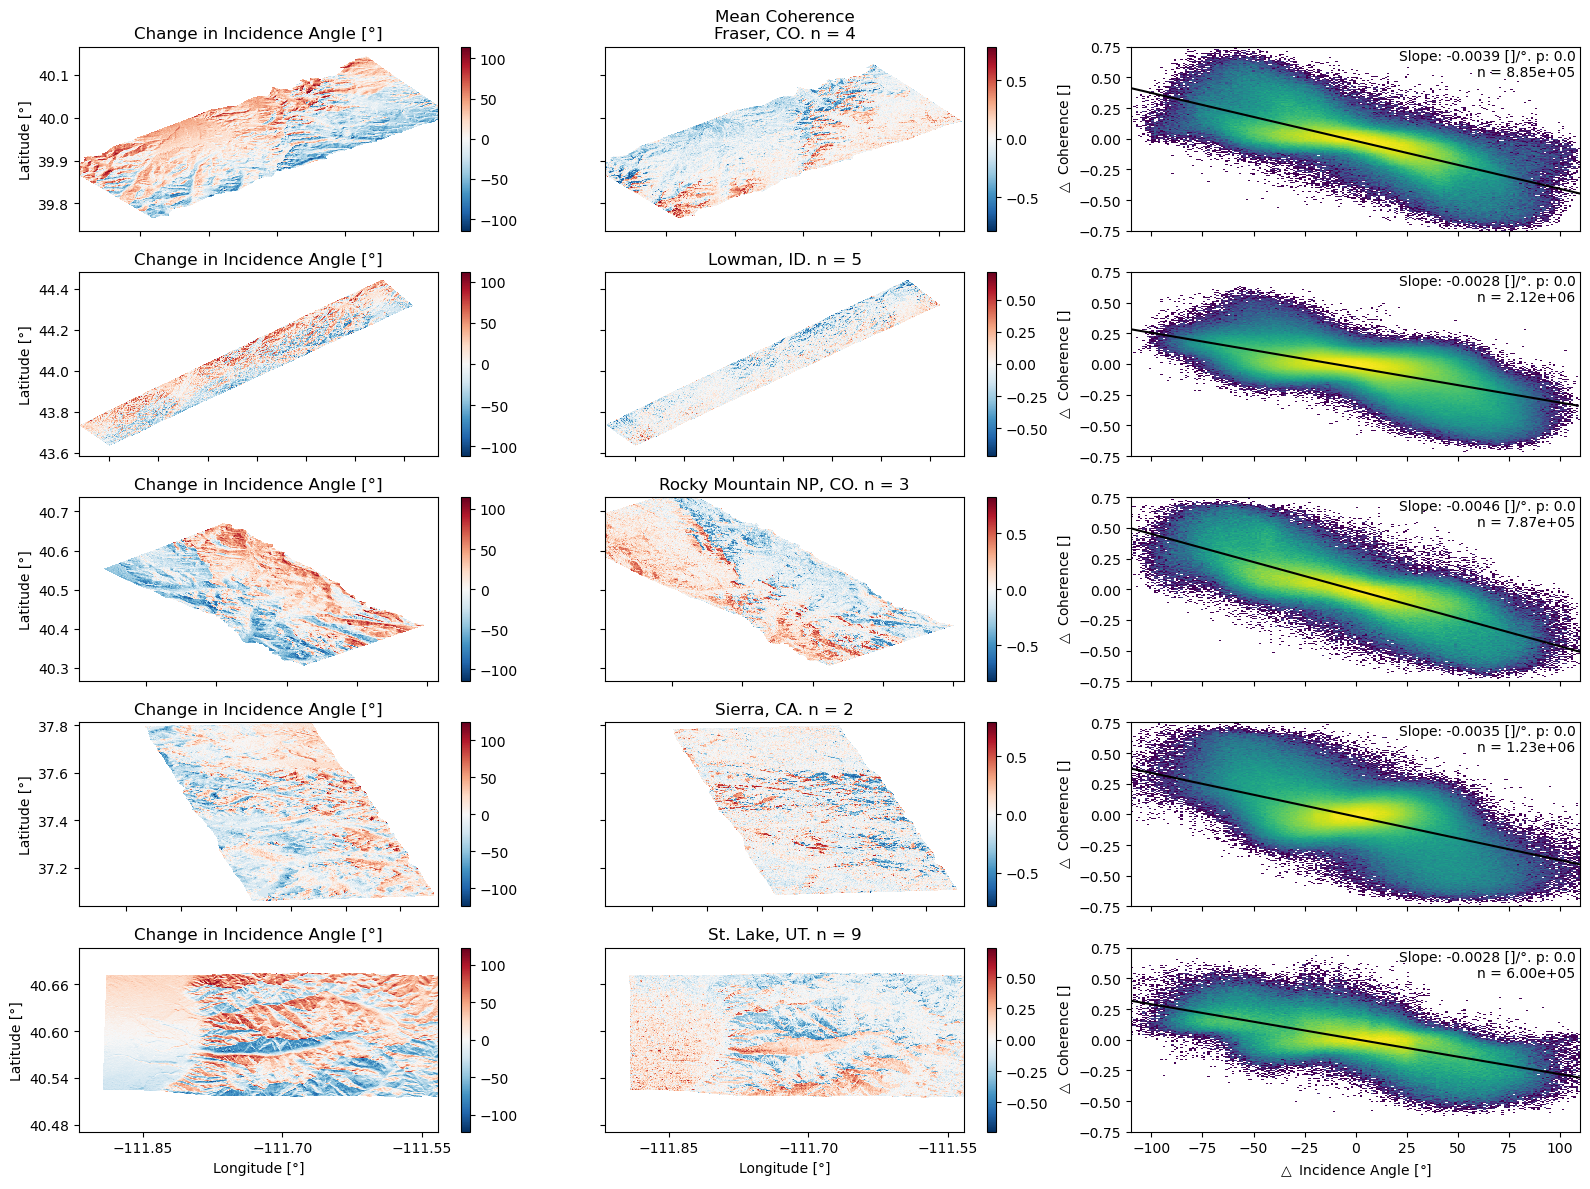

In [68]:
full_fig, full_axes = plt.subplots(5, 3, figsize = (16, 12))
for (stem, ds_full), ax_row in zip({stem:ds for stem, ds in dss.items() if ds.heading.size == 2}.items(), full_axes):

    if ds_full.heading.size == 1: continue
    print(stem)
    site_name = loc_colors[stem.replace('_full', '')]['name']
    # if stem == 'fraser_full': continue
    # if stem == 'lowman_full': continue

    dcors = []
    i = 0
    ds_full = ds_full.sel(pol = 'HH')
    for t1, t2 in product(ds_full.time1, ds_full.time2):
        # if fig_dir.joinpath('incs', f'{stem}_{t1.dt.date.values.ravel()[0]}_{t2.dt.date.values.ravel()[0]}.png').exists(): continue
        # if ds_full.sel(time1= slice(t1 - pd.Timedelta('1 day'), t1 + pd.Timedelta('1 day'))).time1.size != 2: continue
        # if ds_full.sel(time2= slice(t2 - pd.Timedelta('1 day'), t2 + pd.Timedelta('1 day'))).time2.size != 2: continue
        ds = ds_full.sel(time1= slice(t1 - pd.Timedelta('1 day'), t1 + pd.Timedelta('1 day')), time2= slice(t2 - pd.Timedelta('1 day'), t2 + pd.Timedelta('1 day')))
        
        h1 = ds.isel(heading = 0)['cor'].dropna('time1', how = 'all').dropna('time2', how = 'all')
        h2 = ds.isel(heading = 1)['cor'].dropna('time1', how = 'all').dropna('time2', how = 'all')
        if ds['cor'].isel(heading = 1).sel(time1 = h2.time1, time2 = h2.time2).time1.squeeze().size == 0: continue
        if ds['cor'].isel(heading = 0).sel(time1 = h1.time1, time2 = h1.time2).squeeze().time1.size == 0: continue
        
        dinc = np.rad2deg(ds['inc'].isel(heading = 0) - ds['inc'].isel(heading = 1))
        dcor = ds['cor'].isel(heading = 0).sel(time1 = h1.time1, time2 = h1.time2).squeeze() - ds['cor'].isel(heading = 1).sel(time1 = h2.time1, time2 = h2.time2).squeeze()
        index = (ds['cor'].isel(heading = 0).sel(time1 = h1.time1, time2 = h1.time2).squeeze() > 0.4) & (ds['cor'].isel(heading = 1).sel(time1 = h2.time1, time2 = h2.time2).squeeze() > 0.4)
        # dcor = dcor
        fig, axes = plt.subplots(2, 1)
        dinc.plot(ax = axes[0])
        dcor.plot(ax = axes[1])
        plt.tight_layout()
        plt.savefig(fig_dir.joinpath('incs', f'{stem}_{t1.dt.date.values.ravel()[0]}_{t2.dt.date.values.ravel()[0]}'))
        plt.close()
        dcors.append(dcor.expand_dims(img = [i]))
        i += 1
    
    # fig, axes = plt.subplots(1, 3, figsize = (12, 8), width_ratios=[5,5,7])
    axes = ax_row
    mcor = xr.concat(dcors, 'img').mean('img')
    
    # select pixels that get push to 65deg+
    high_incs = (ds.isel(heading = 0)['inc'] > np.deg2rad(65)) | (ds.isel(heading = 1)['inc'] > np.deg2rad(65))
    
    mcor.plot(ax= axes[1], cbar_kwargs = {'label': ''}) # Mean Coherence Change []
    dinc.plot(ax = axes[0], cbar_kwargs = {'label': ''}) # Incidence Angle Change [°]
    for ax in axes: 
        ax.set_xlabel('Longitude [°]')
    axes[1].set_ylabel('')
    axes[0].set_title('')
    axes[0].set_ylabel('Latitude [°]')
    if stem == 'fraser_full':
        axes[1].set_title(f"Mean Coherence\n{site_name}. n = {i}")
    else:
        axes[1].set_title(f"{site_name}. n = {i}")
    
    y,x = mcor.values.ravel(), dinc.values.ravel() #.where(high_incs)
    ix = (~np.isnan(x)) & (~np.isnan(y))
    x, y = x[ix], y[ix]
    axes[2].hist2d(x, y, bins = 200, range= [[-110, 110], [-0.75, 0.75]], norm=mpl.colors.LogNorm())
    
    # linear fit
    inc1, inc2 = ds.isel(heading = 0)['inc'].data.ravel(), ds.isel(heading = 1)['inc'].data.ravel()
    inc1, inc2 = np.rad2deg(inc1), np.rad2deg(inc2)
    y, x = mcor.values.ravel(), dinc.values.ravel()
    x, y, inc1, inc2 = [np.expand_dims(a, axis = -1) for a in [x, y, inc1, inc2]]
    df = pd.DataFrame(np.concatenate([x, y, inc1, inc2], axis = 1), columns = ['inc_change', 'cor_change', 'inc1', 'inc2'])
    df = df.dropna()
    # this weird set of code takes all the negative changes in incidence angle and makes them positive and reverses the sign on their coherence change
    # df.loc[df.inc_change < 0, 'cor_change'] = -df.loc[df.inc_change < 0, 'cor_change']
    # old_inc1 = df.loc[df.inc_change < 0, 'inc1']
    # df.loc[df.inc_change < 0, 'inc1'] = df.loc[df.inc_change < 0, 'inc2']
    # df.loc[df.inc_change < 0, 'inc2'] = old_inc1
    # df.loc[df.inc_change < 0, 'inc_change'] = -df.loc[df.inc_change < 0, 'inc_change']
    x = df['inc_change']
    y = df['cor_change']

    lm = linregress(x = x, y = y)
    xs = np.linspace(np.min(x), np.max(x), 100)
    ys = lm.slope * xs + lm.intercept
    axes[2].plot(xs, ys, color = 'black')
    axes[2].text(0.99, 0.99, f'Slope: {lm.slope:.4f} []/°. p: {lm.pvalue}\nn = {len(df):.2e}', transform=ax.transAxes, ha = 'right', va = 'top')
    print(f'Inc Slope: {lm.slope} []/°. p: {lm.pvalue}. n = {len(df)}')
    
    axes[2].set_xlabel('$\\triangle$ Incidence Angle [°]')
    axes[2].set_ylabel('$\\triangle$ Coherence []')

for ax in full_axes[:-1,:].ravel(): ax.set_xlabel(''); ax.set_xticklabels([])
for ax in full_axes[-1,:2].ravel(): 
    ax.ticklabel_format(axis = 'both', style = 'plain',useOffset = False)
    ax.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax.yaxis.set_major_locator(plt.MaxNLocator(4))


for ax in full_axes[:,1].ravel(): ax.set_yticklabels([])

# full_axes[0, 1].set_title('Mean Change in Coherence')
for ax in full_axes[:, 0].ravel(): ax.set_title('Change in Incidence Angle [°]')

plt.tight_layout()
full_fig.savefig(fig_dir.joinpath(f'full_dinc.png'))
plt.show()

Text(0.5, 0, '$\\triangle$')

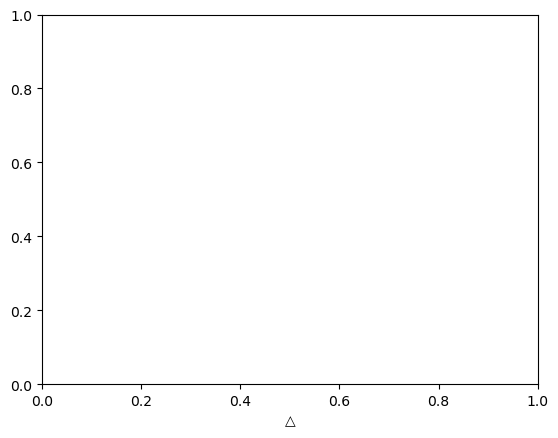

In [59]:
plt.subplots()
plt.xlabel('$\\triangle$')